In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Data/hawaii.sqlite")
insp = inspect(engine)

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [25]:
# View all of the classes that automap found
print(insp.get_table_names())

['measurement', 'station']


In [26]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
sesh = Session(engine)

# Exploratory Precipitation Analysis

In [96]:
# Find the most recent date in the data set.
columns = insp.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])
most_recent = engine.execute('SELECT max(date) FROM measurement').fetchall()
most_recent = most_recent[0][0]
print(f'the most recent date taken in the database was taken on {most_recent}')

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
the most recent date taken in the database was taken on 2017-08-23


one year from the last taken date:2017-08-23 would be: 2016-08-23


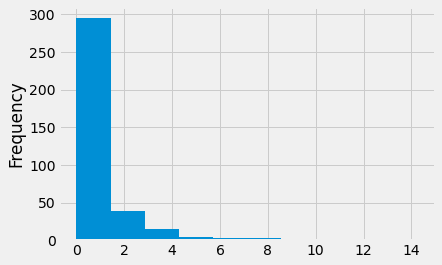

In [120]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
import datetime as dt
start_date = dt.datetime(2016, 8, 23)

# Calculate the date one year from the last date in data set.
print(f'one year from the last taken date:{most_recent} would be: 2016-08-23')

# Perform a query to retrieve the data and precipitation scores
results = sesh.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= start_date).all()

results

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = [{"date": result[0], "precipitation": result[1]} for result in results]
prcp
# Sort the dataframe by date
precip_df = pd.DataFrame(prcp).set_index("date")
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.groupby('date')['precipitation'].sum().plot.hist();


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()